In [15]:
from matplotlib import pyplot as plt
import numpy as np
import math
import os
import numpy as np
import sigpy as sp
import sigpy.plot as pl
from cmcrameri import cm

from dipy.segment.mask import median_otsu
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
import numpy as np
import nrrd
import scikit_posthocs as sp


import sys
sys.path.append("/home/ahannum/Documents/Phase/cDTI_python")
from mystic_mrpy.Data_Import.Diffusion   import *
from mystic_mrpy.Data_Sorting.Diffusion  import *
from mystic_mrpy.Diffusion.DWI  import *
from mystic_mrpy.Diffusion.Gibbs         import *
from mystic_mrpy.Diffusion.Registration  import *
from mystic_mrpy.Diffusion.Rejection     import *
from mystic_mrpy.Diffusion.Respiratory   import *
from mystic_mrpy.Diffusion.Averaging     import *
from mystic_mrpy.Diffusion.Denoising     import *
from mystic_mrpy.Diffusion.Interpolation import *
from mystic_mrpy.Diffusion.Segmentation_Matrix_DTI import *
from mystic_mrpy.Diffusion.DTI import *
from mystic_mrpy.Diffusion.cDTI import *
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat

import seaborn as sns
sns.set(style='darkgrid', palette='Set2')

In [16]:
# Load in Spatial Gradients

volunteers=[1,2,3,4,5,7,8,9,10,11]
slope_m0 = np.zeros((128, 128, 6, 4, 5, 8, 10))
slope_m1 = np.zeros((128, 128, 6, 4, 5, 8, 10))
slope_m2 = np.zeros((128, 128, 6, 4, 5, 8, 10))

for vv in range(10):
    volunteer = str(volunteers[vv])
    inpath = 'Data/V00' + volunteer 
    savename = os.path.join(inpath,'M0_slope.npy')
    slope_m0[:,:,:,:,:,:,vv] = np.load(savename)

    savename = os.path.join(inpath,'M1_slope.npy')
    slope_m1[:,:,:,:,:,:,vv] = np.load(savename)
    
    savename = os.path.join(inpath,'M2_slope.npy')
    slope_m2[:,:,:,:,:,:,vv] = np.load(savename)
    

In [17]:
boostrap_m0 = np.zeros((128,128,6,4,10))
boostrap_m1 = np.zeros((128,128,6,4,10))
boostrap_m2 = np.zeros((128,128,6,4,10))


for vv in range(10):

    volunteers=[1,2,3,4,5,7,8,9,10,11]
    volunteer = str(volunteers[vv])
    inpath = '/home/ahannum/Documents/Phase/Data/V00' + volunteer 

    savename = os.path.join(inpath,'M0_spatial_avg_boostrap_analysis.npz')
    boostrap_m0[:,:,:,:,vv] = np.load(savename)['med']

    savename = os.path.join(inpath,'M1_spatial_avg_boostrap_analysis.npz')
    boostrap_m1[:,:,:,:,vv] = np.load(savename)['med']

    savename = os.path.join(inpath,'M2_spatial_avg_boostrap_analysis.npz')
    boostrap_m2[:,:,:,:,vv] = np.load(savename)['med']




In [18]:
## TD avg
volunteers=[1,2,3,4,5,7,8,9,10,11]

td_m0 = np.zeros((128,128,6,4,8,10)) #[lb ub, #volunteers, #slices,TD]
td_m1 = np.zeros((128,128,6,4,8,10)) #[lb ub, #volunteers, #slices,TD]
td_m2 = np.zeros((128,128,6,4,8,10)) #[lb ub, #volunteers, #slices,TD]


M0_mask = np.zeros((128,128,6,4,5,8,10)) #[lb ub, #volunteers, #slices,TD]
M1_mask = np.zeros((128,128,6,4,5,8,10)) #[lb ub, #volunteers, #slices,TD]
M2_mask = np.zeros((128,128,6,4,5,8,10)) #[lb ub, #volunteers, #slices,TD]

for vv in range(10):
    # For each volunteer 
    M0_mag = np.zeros((128,128,6,4,5,8))
    M1_mag = np.zeros((128,128,6,4,5,8))
    M2_mag = np.zeros((128,128,6,4,5,8))

    M0_phs = np.zeros((128,128,6,4,5,8))
    M1_phs = np.zeros((128,128,6,4,5,8))
    M2_phs = np.zeros((128,128,6,4,5,8))


    volunteer = str(volunteers[vv])
    print(volunteer, end = ' ')
    inpath = '/home/ahannum/Documents/Phase/Data/V00' + volunteer 
    name = inpath.split('/')
    namejoin = '/'.join(name[:-1])

    num = 0
    for num in range(3):
        nii_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.nii')]
        bval_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.bvals')]
        bvec_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.bvecs')]
        mask_files   = [_ for _ in os.listdir(inpath) if _.endswith('new.nrrd')]
        

        nii_files.sort()
        bval_files.sort()
        bvec_files.sort()
        mask_files.sort()
        
        data,affine, voxsize = load_nifti(os.path.join(inpath, nii_files[num]), return_voxsize=True)
        bvals = np.loadtxt(os.path.join(inpath,bval_files[num])) 
        bvecs = np.loadtxt(os.path.join(inpath,bvec_files[num]))
        mask,header =  nrrd.read(os.path.join(inpath, mask_files[num]))
        
        mask = mask.astype('float')
        mask[mask==0] = np.nan
        
        
        data1,bvals_sort,bvecs_sort = stacked2sorted(data,bvals,bvecs.T)
        
        ims = np.stack((data1[:,:,:,:,:5],data1[:,:,:,:,5:10],data1[:,:,:,:,10:15],
                            data1[:,:,:,:,15:20],data1[:,:,:,:,20:25],data1[:,:,:,:,25:30],
                            data1[:,:,:,:,30:35],data1[:,:,:,:,35:40]),axis = -1)  
            
        
        mag = abs(ims)
        phs = np.angle(ims)
        mask_rep = np.tile(mask[:,:,:,np.newaxis,np.newaxis,np.newaxis],(1,1,1,ims.shape[3],ims.shape[4],ims.shape[5]))
        mask_rep[mask_rep ==0] = np.nan
        
        if num == 0:
            M0_mag[:,:,:,:,:,:] = mag #* mask_rep
            M0_phs[:,:,:,:,:,:,] = phs #*mask_rep
            M0_mask[:,:,:,:,:,:,vv] = mask_rep #*mask_rep
            
        if num == 1:
            M1_mag[:,:,:,:,:,:,] = mag #* mask_rep
            M1_phs[:,:,:,:,:,:] = phs #*mask_rep
            M1_mask[:,:,:,:,:,:,vv] = mask_rep #*mask_rep
            
        if num == 2:
            M2_mag[:,:,:,:,:,:] = mag #* mask_rep
            M2_phs[:,:,:,:,:,:] = phs #*mask_rep
            M2_mask[:,:,:,:,:,:,vv] = mask_rep #*mask_rep


1 2 3 4 5 7 8 9 10 11 

In [19]:
td_m0 = np.nanmean(slope_m0,axis = -3)
td_m1 =np.nanmean(slope_m1,axis = -3)
td_m2 = np.nanmean(slope_m2,axis = -3)

<ipython-input-19-f2af0c7f1642>:1: RuntimeWarning: Mean of empty slice
  td_m0 = np.nanmean(slope_m0,axis = -3)
<ipython-input-19-f2af0c7f1642>:2: RuntimeWarning: Mean of empty slice
  td_m1 =np.nanmean(slope_m1,axis = -3)
<ipython-input-19-f2af0c7f1642>:3: RuntimeWarning: Mean of empty slice
  td_m2 = np.nanmean(slope_m2,axis = -3)


In [20]:
import pandas as pd

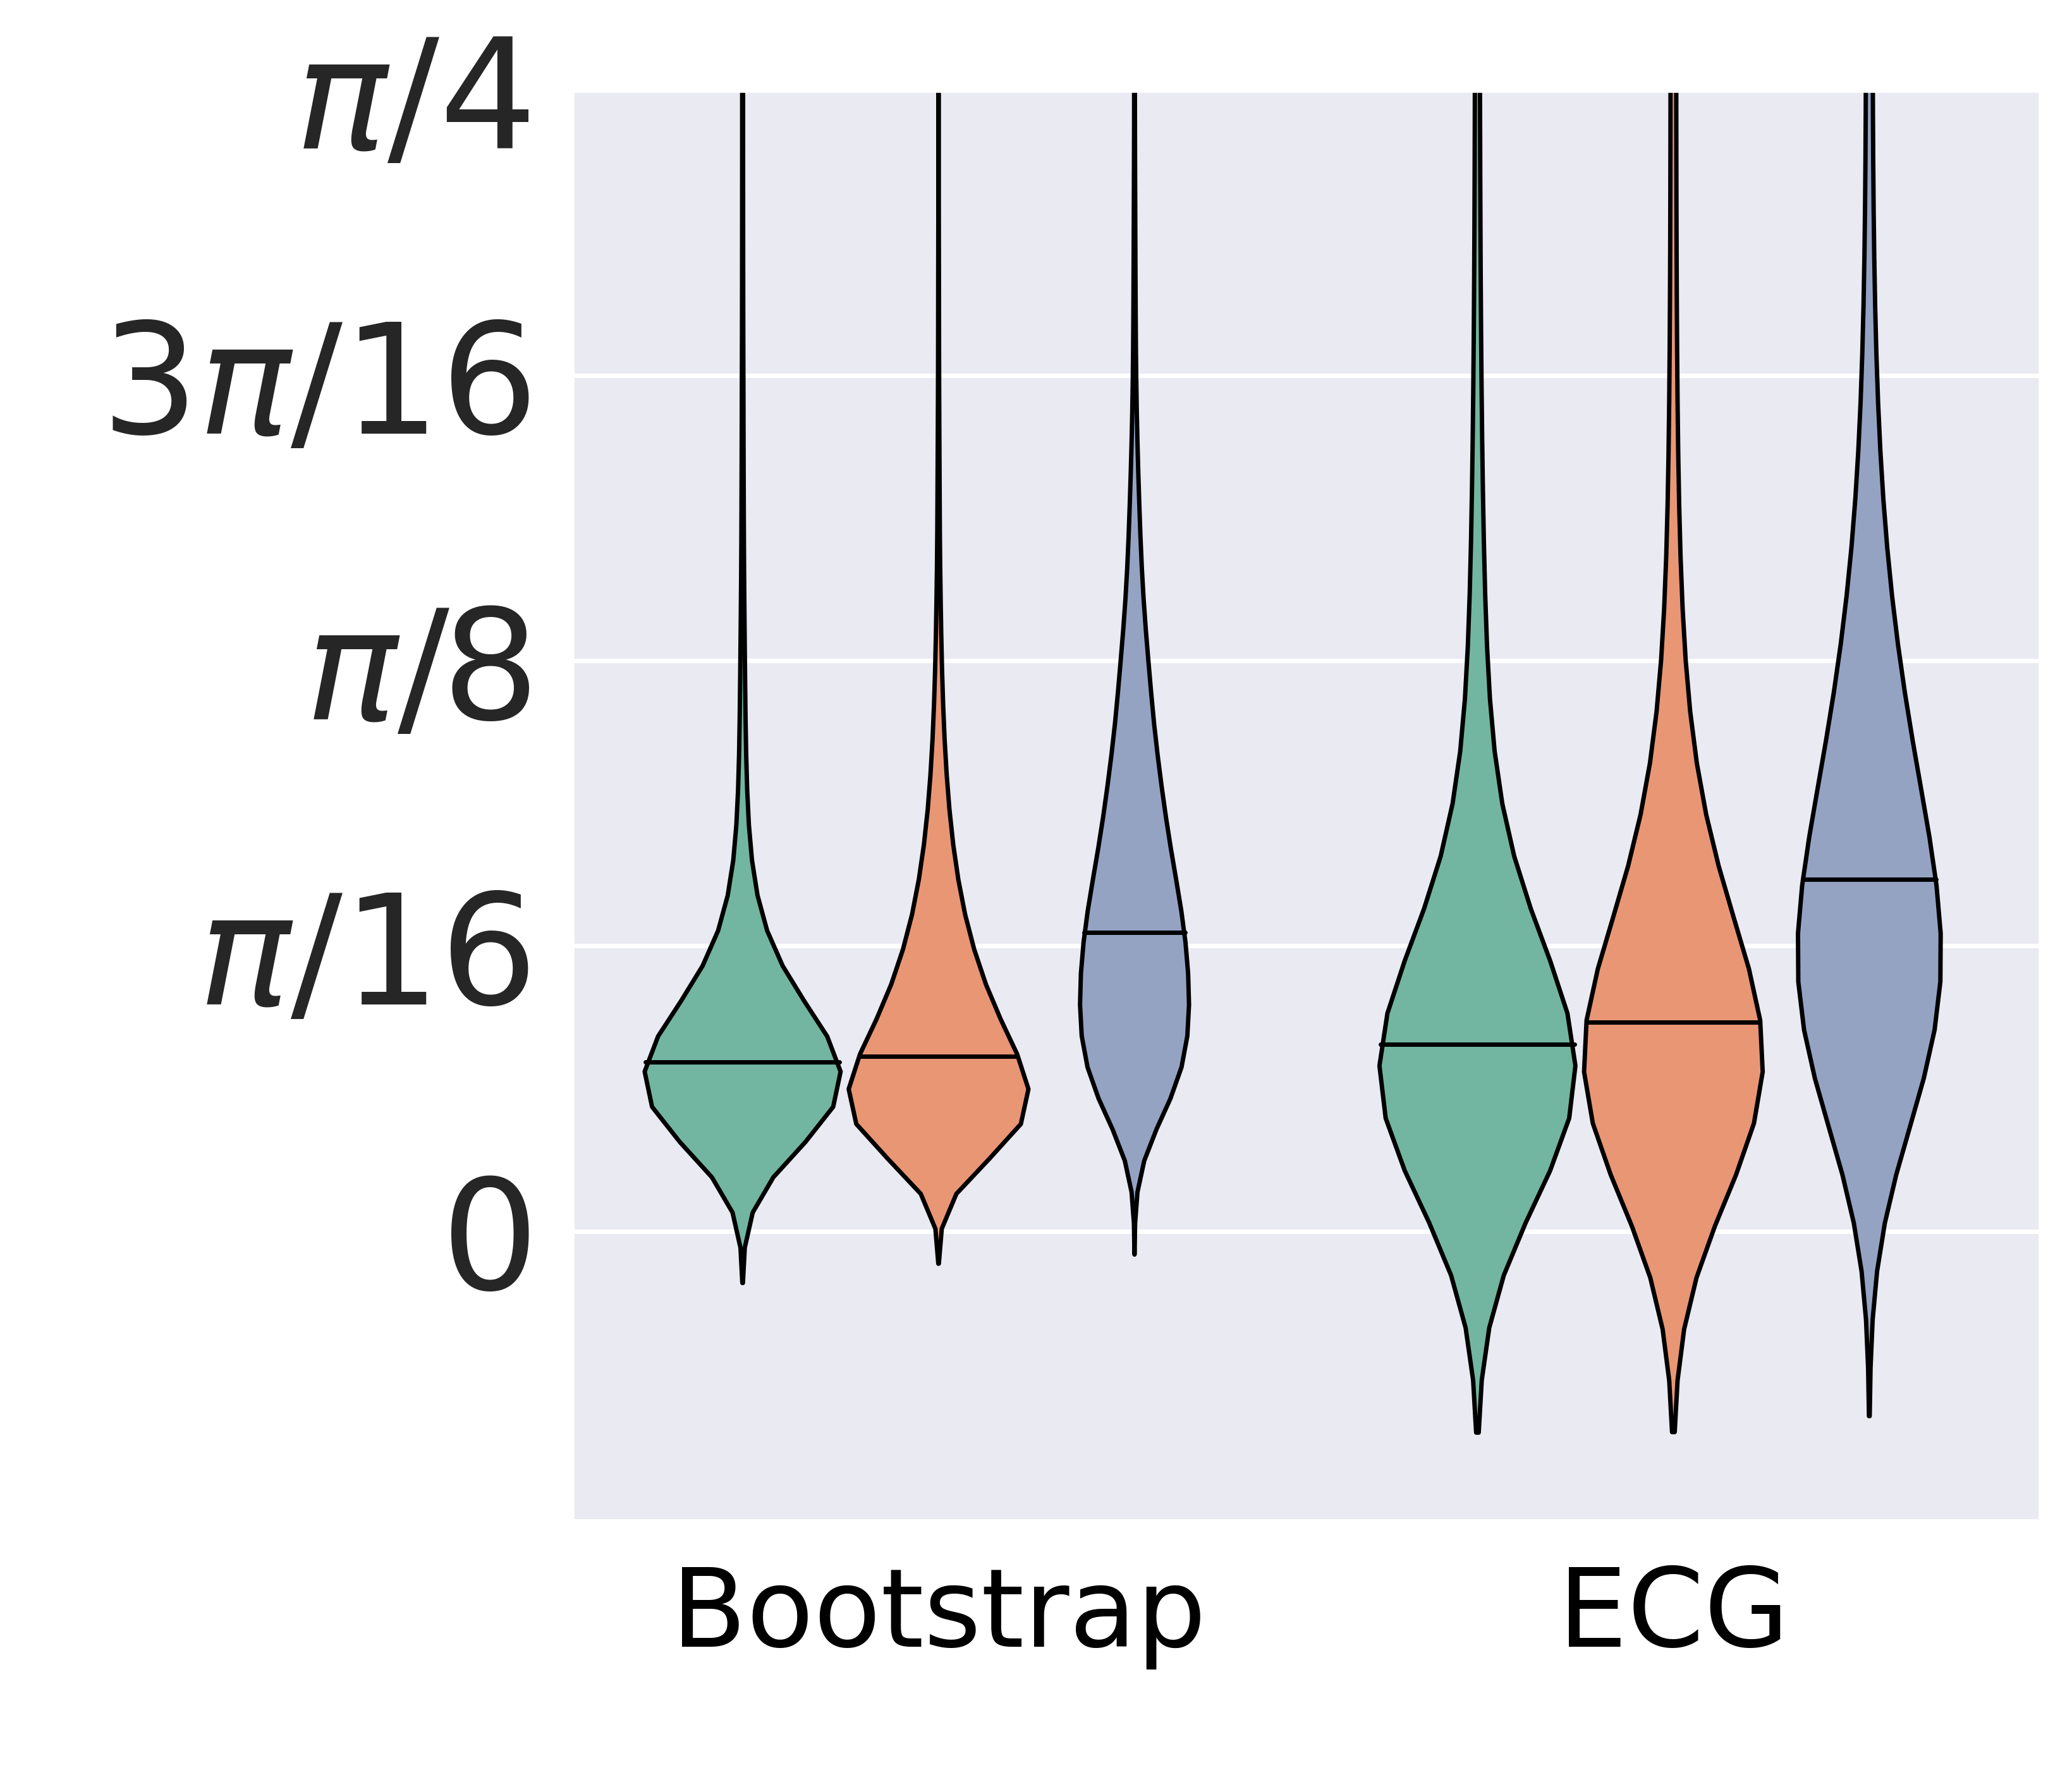

In [21]:

dd = 1
sl = 3


med0 = boostrap_m0[:,:,sl,dd,:].reshape((128*128*10))
med1 = boostrap_m1[:,:,sl,dd,:].reshape((128*128*10))
med2 = boostrap_m2[:,:,sl,dd,:].reshape((128*128*10))

boostrap = np.append(med0,(med1,med2))
motion_b = np.repeat(["M0","M1","M2"],len(med0))
timeA = np.repeat(0,len(boostrap))

med0 =td_m0[:,:,sl,dd,:,:].reshape((128*128*8*10))
med1 = td_m1[:,:,sl,dd,:,:].reshape((128*128*8*10))
med2 = td_m2[:,:,sl,dd,:,:].reshape((128*128*8*10))
td = np.append(med0,(med1,med2))
motion_td = np.repeat(["M0","M1","M2"],len(med0))
timeB = np.repeat(1,len(td))


phs_all = np.append(boostrap,(td))
motion = np.append(motion_b,(motion_td))
time = np.append(timeA, (timeB))

data = pd.DataFrame()
data['phs'] = phs_all
data['motion'] = motion
data['type'] = time


fig, axes = plt.subplots(1, 1, figsize=(6,6),sharex=True,sharey = True,dpi=500)

sns.violinplot(data=data,hue = 'motion',y = 'phs',palette = "Set2", x = 'type',
    ax = axes,linewidth = 4 ,legend = False,linecolor= 'black',inner='quartile',
    split =False,bw=0.2)

for ii in [9,11,12,14,15,17,18,20,21,23,24,26]:
    axes.get_children()[ii].set_alpha(0)
    axes.get_children()[ii].set_linewidth(10)
    


axes.set_xticks([0,1])
axes.set_xticklabels(["Bootstrap","ECG"],size = 25,color = 'black')
axes.tick_params(axis='y', which='major', labelsize=35)
axes.set_yticks([0,math.pi/16,math.pi/8,3*math.pi/16,math.pi/4])
axes.set_yticklabels(['$0$','$\pi/16$','$\pi/8$','$3\pi/16$','$\pi/4$',],size = 35,rotation = 0)
axes.set_ylim([-0.2,math.pi/4])
axes.set_ylabel('radians',color='white')
axes.set_xlabel('radians',color='white')

for ii in range(6):
    axes.get_children()[ii].set_edgecolor('black')
    axes.get_children()[ii].set_linewidth(1)

for ii in [10,13,16,19,22,25]:
    axes.get_children()[ii].set_linewidth(1)
    axes.get_children()[ii].set_linestyle('solid')
    axes.get_children()[ii].set_color('black')

#sns.pointplot(x = 'motion', y='phs', data=data, estimator=np.mean)
axes.legend([],[], frameon=False)
plt.show()


In [22]:
axes.get_children()

 Text(0.5, 1.0, ''),
 Text(0.0, 1.0, ''),
 Text(1.0, 1.0, ''),

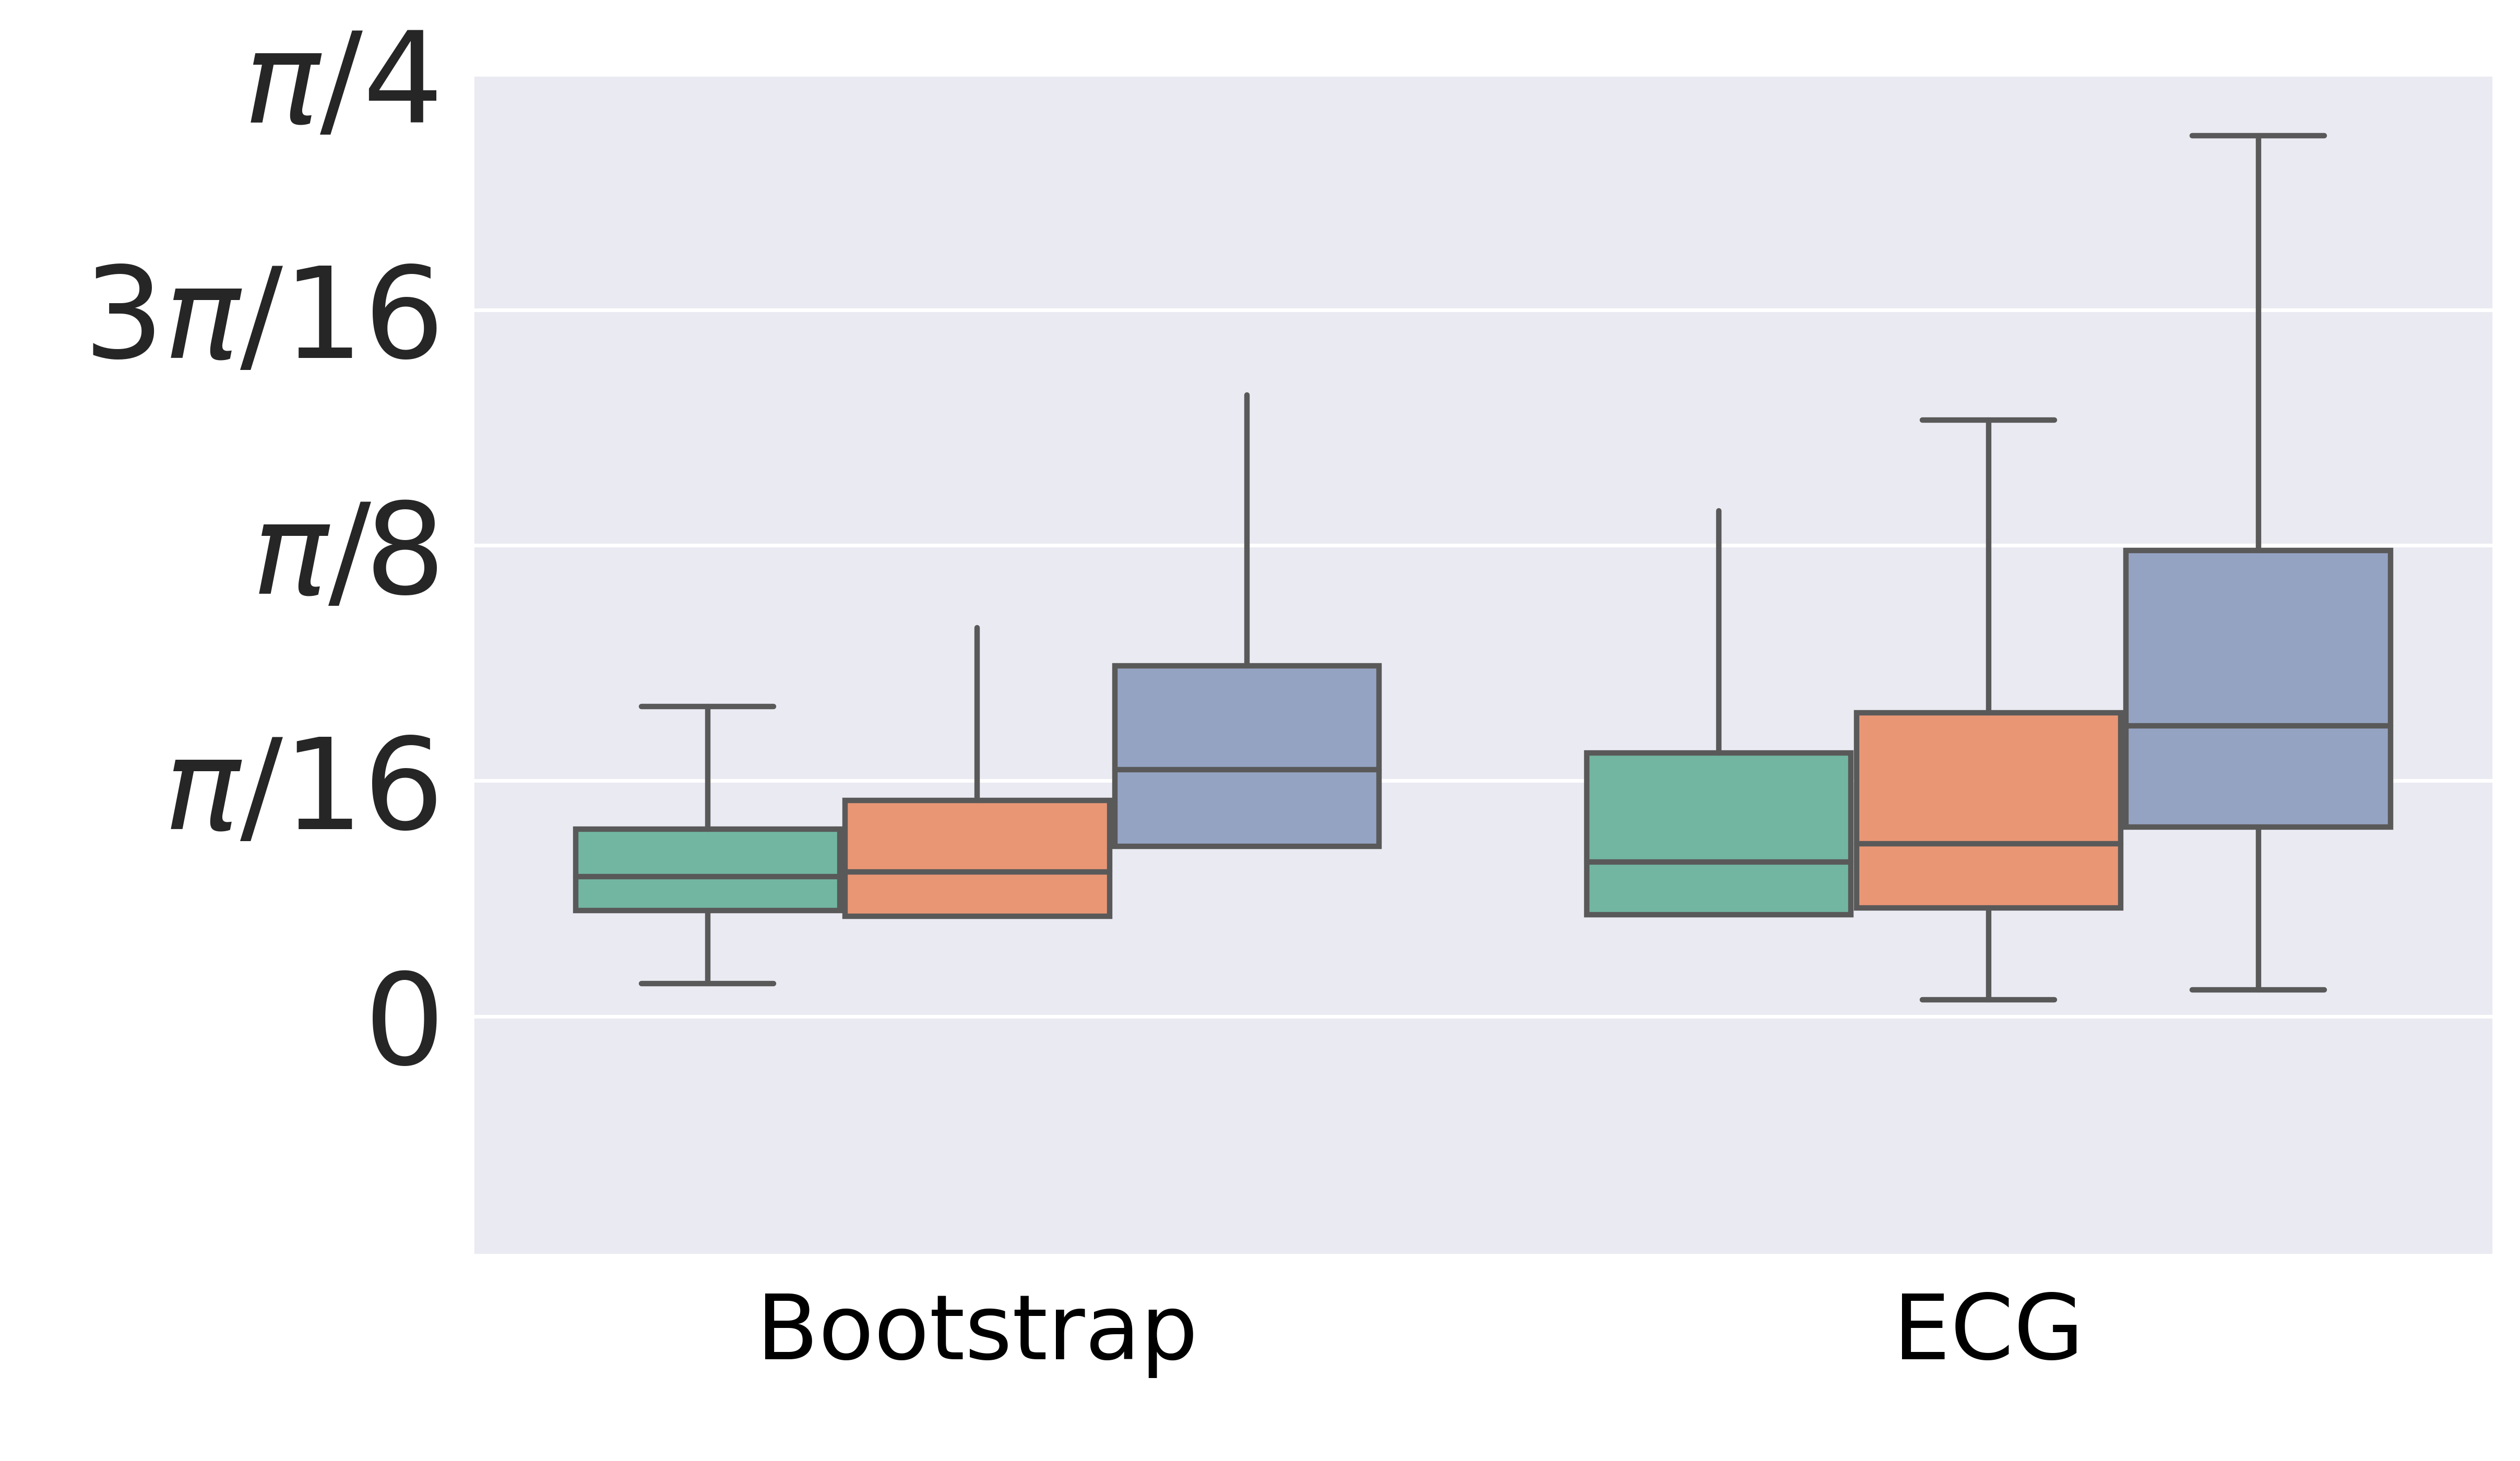

In [23]:

dd = 1
sl = 3


med0 = boostrap_m0[:,:,sl,dd,:].reshape((128*128*10))
med1 = boostrap_m1[:,:,sl,dd,:].reshape((128*128*10))
med2 = boostrap_m2[:,:,sl,dd,:].reshape((128*128*10))

boostrap = np.append(med0,(med1,med2))
motion_b = np.repeat(["M0","M1","M2"],len(med0))
timeA = np.repeat(0,len(boostrap))

med0 =td_m0[:,:,sl,dd,:,:].reshape((128*128*8*10))
med1 = td_m1[:,:,sl,dd,:,:].reshape((128*128*8*10))
med2 = td_m2[:,:,sl,dd,:,:].reshape((128*128*8*10))
td = np.append(med0,(med1,med2))
motion_td = np.repeat(["M0","M1","M2"],len(med0))
timeB = np.repeat(1,len(td))


phs_all = np.append(boostrap,(td))
motion = np.append(motion_b,(motion_td))
time = np.append(timeA, (timeB))

data = pd.DataFrame()
data['phs'] = phs_all
data['motion'] = motion
data['type'] = time


fig, axes = plt.subplots(1, 1, figsize=(10,6),sharex=True,sharey = True,dpi=500)

#sns.violinplot(data=data,hue = 'motion',y = 'phs',palette = "Set2", x = 'type',
#    ax = axes,linewidth = 4 ,legend = False,linecolor= 'black',inner='quartile',
#    split =False,bw=0.2)


sns.boxplot(data=data,hue = 'motion',y = 'phs',palette = "Set2", x = 'type',fliersize = 0)
#    ax = axes,linewidth = 4 ,legend = False,linecolor= 'black',inner='quartile',
#    split =False,bw=0.2)



for ii in [9,11,12,14,15,17,18,20,21,23,24,26]:
    axes.get_children()[ii].set_alpha(0)
    axes.get_children()[ii].set_linewidth(10)
    axes.get_children()[ii].set_linestyle('-')


axes.set_xticks([0,1])
axes.set_xticklabels(["Bootstrap","ECG"],size = 25,color = 'black')
axes.tick_params(axis='y', which='major', labelsize=35)
axes.set_yticks([0,math.pi/16,math.pi/8,3*math.pi/16,math.pi/4])
axes.set_yticklabels(['$0$','$\pi/16$','$\pi/8$','$3\pi/16$','$\pi/4$',],size = 35,rotation = 0)
axes.set_ylim([-0.2,math.pi/4])
axes.set_ylabel('radians',color='white')
axes.set_xlabel('radians',color='white')

#xes.get_children()[12].set_color('blue')
#sns.pointplot(x = 'motion', y='phs', data=data, estimator=np.mean)
axes.legend([],[], frameon=False)
plt.show()


In [24]:
boostrap_m0 = np.zeros((128,128,6,4,10))
boostrap_m1 = np.zeros((128,128,6,4,10))
boostrap_m2 = np.zeros((128,128,6,4,10))


for vv in range(10):

    volunteers=[1,2,3,4,5,7,8,9,10,11]
    volunteer = str(volunteers[vv])
    inpath = '/home/ahannum/Documents/Phase/Data/V00' + volunteer 

    savename = os.path.join(inpath,'M0_spatial_std_boostrap_analysis.npz')
    boostrap_m0[:,:,:,:,vv] = np.load(savename)['med']

    savename = os.path.join(inpath,'M1_spatial_std_boostrap_analysis.npz')
    boostrap_m1[:,:,:,:,vv] = np.load(savename)['med']

    savename = os.path.join(inpath,'M2_spatial_std_boostrap_analysis.npz')
    boostrap_m2[:,:,:,:,vv] = np.load(savename)['med']


td_m0 = np.nanstd(slope_m0,axis = -3)
td_m1 =np.nanstd(slope_m1,axis = -3)
td_m2 = np.nanstd(slope_m2,axis = -3)

/home/ahannum/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


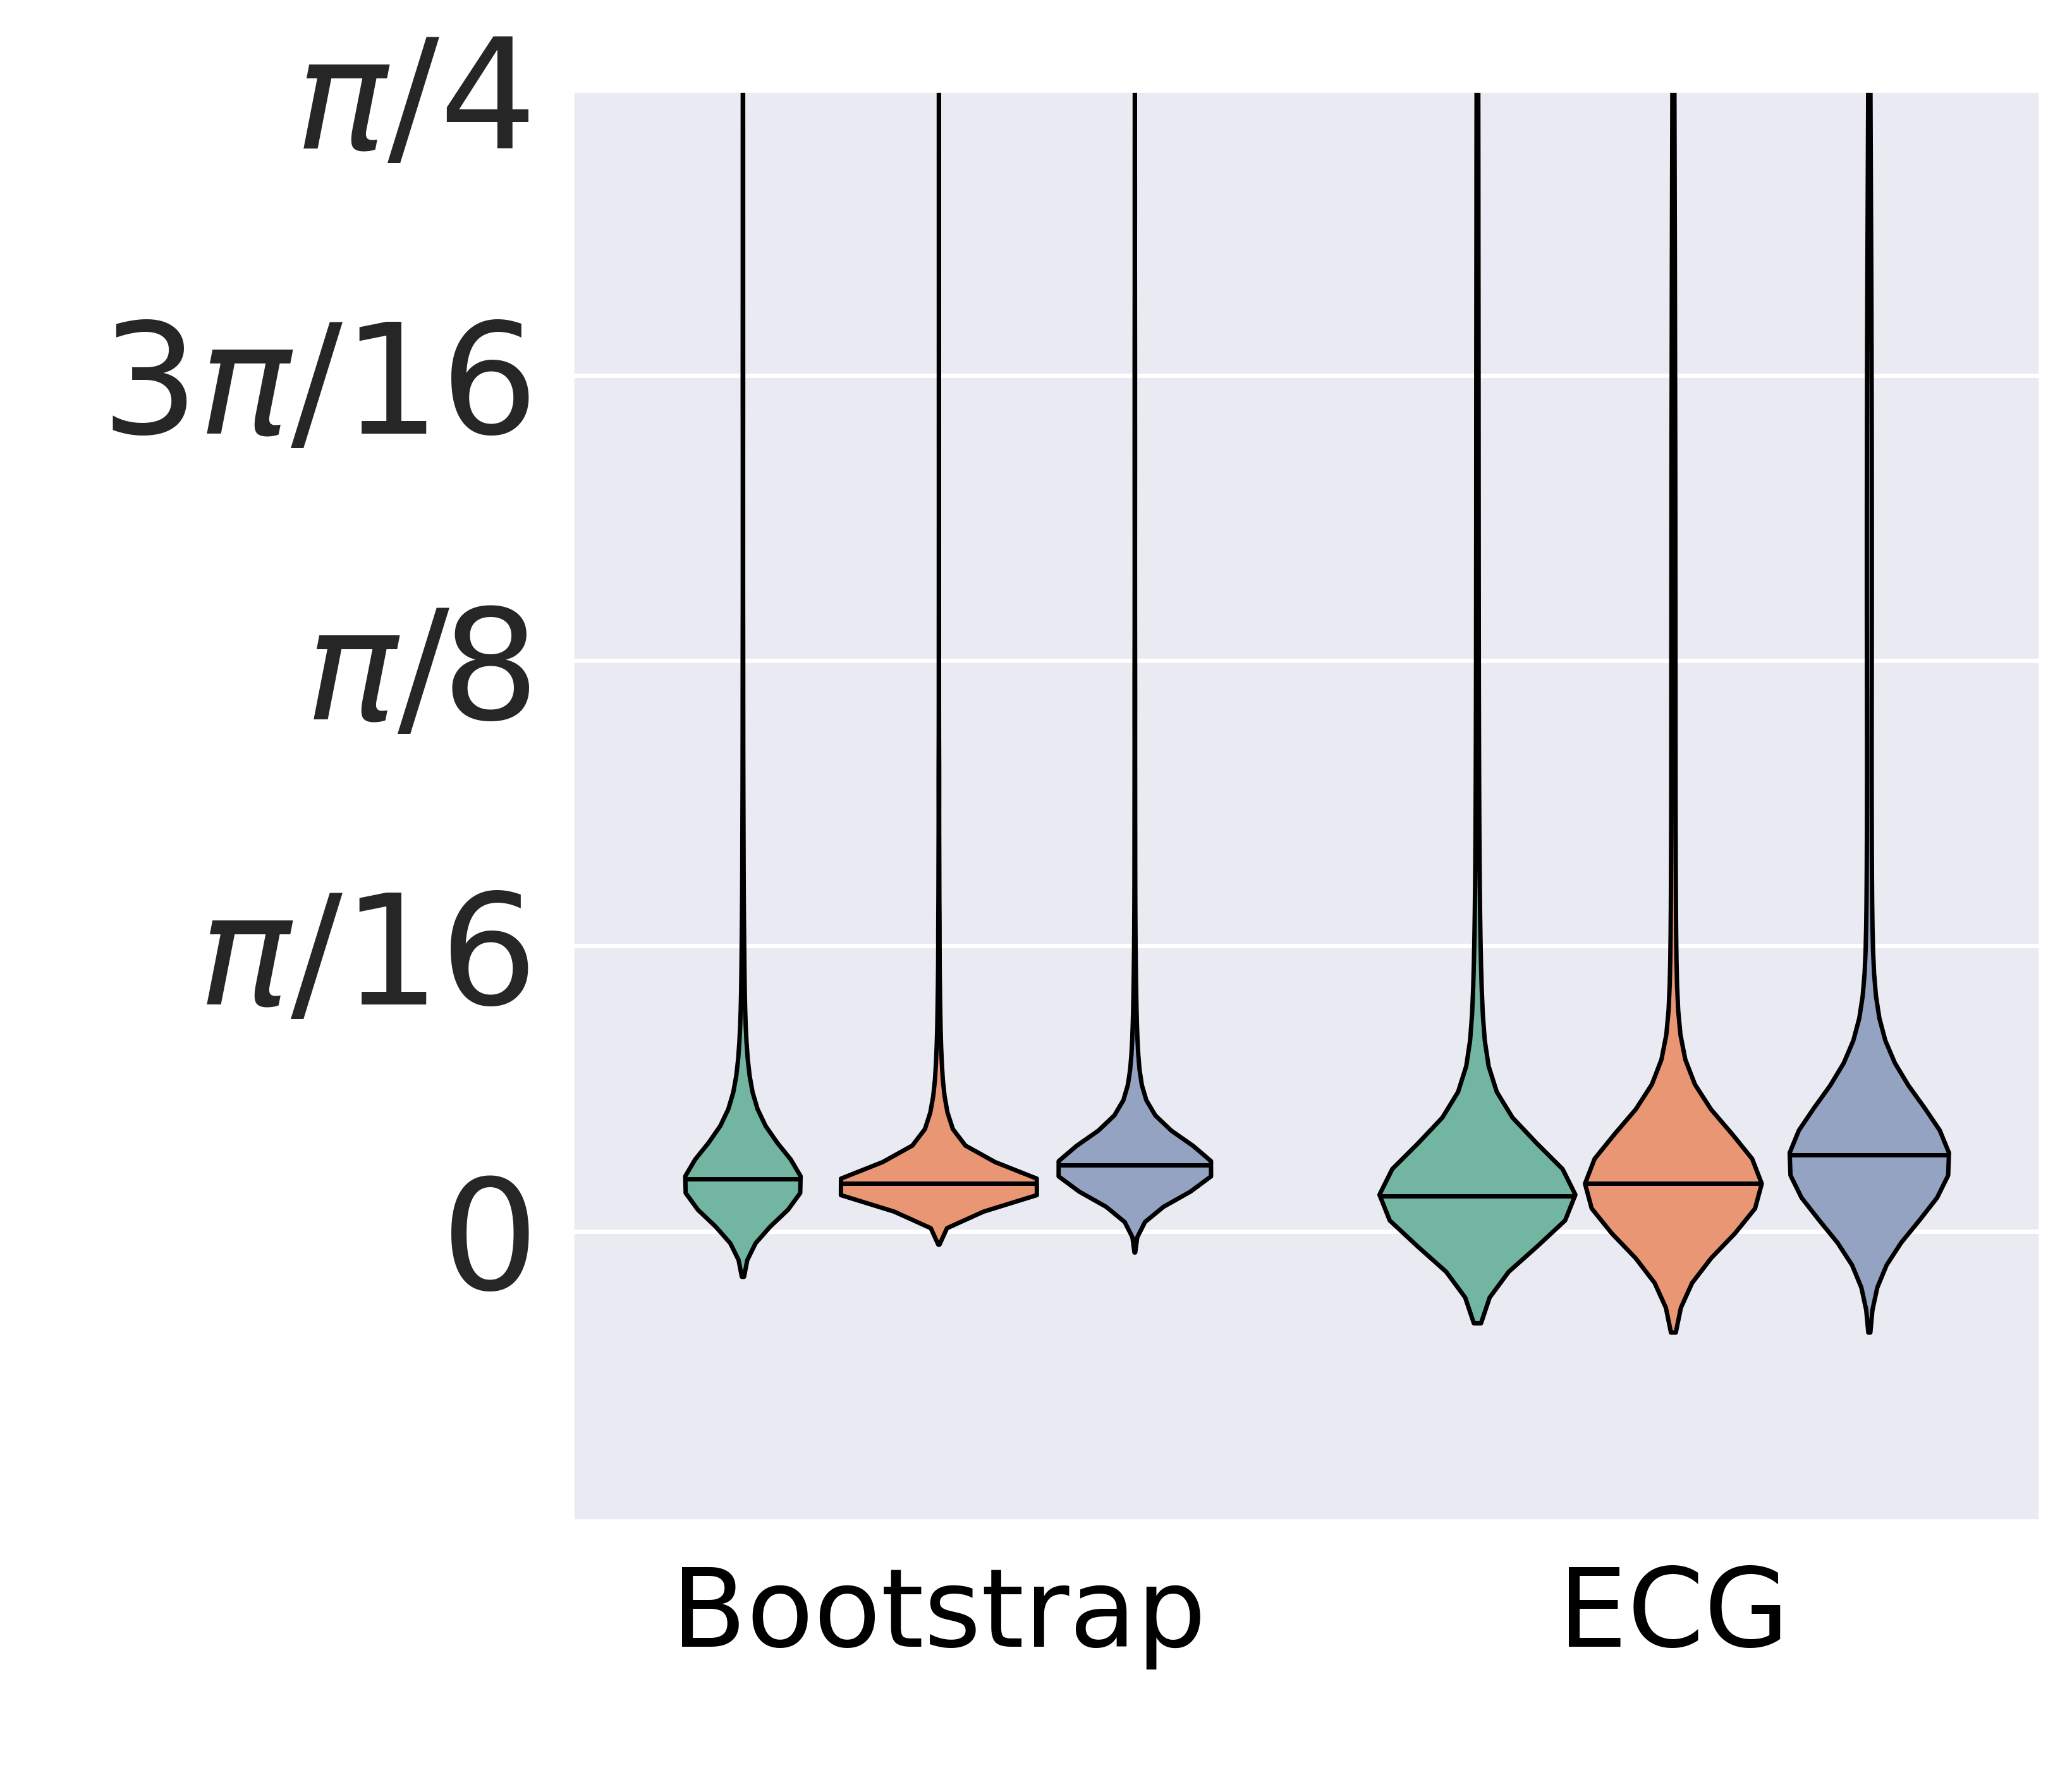

In [26]:

dd = 1
sl = 3


med0 = boostrap_m0[:,:,sl,dd,:].reshape((128*128*10))
med1 = boostrap_m1[:,:,sl,dd,:].reshape((128*128*10))
med2 = boostrap_m2[:,:,sl,dd,:].reshape((128*128*10))

boostrap = np.append(med0,(med1,med2))
motion_b = np.repeat(["M0","M1","M2"],len(med0))
timeA = np.repeat(0,len(boostrap))

med0 =td_m0[:,:,sl,dd,:,:].reshape((128*128*8*10))
med1 = td_m1[:,:,sl,dd,:,:].reshape((128*128*8*10))
med2 = td_m2[:,:,sl,dd,:,:].reshape((128*128*8*10))
td = np.append(med0,(med1,med2))
motion_td = np.repeat(["M0","M1","M2"],len(med0))
timeB = np.repeat(1,len(td))


phs_all = np.append(boostrap,(td))
motion = np.append(motion_b,(motion_td))
time = np.append(timeA, (timeB))

data = pd.DataFrame()
data['phs'] = phs_all
data['motion'] = motion
data['type'] = time


fig, axes = plt.subplots(1, 1, figsize=(6,6),sharex=True,sharey = True,dpi=500)

sns.violinplot(data=data,hue = 'motion',y = 'phs',palette = "Set2", x = 'type',
    ax = axes,linewidth = 4 ,legend = False,linecolor= 'black',inner='quartile',
    split =False,bw=0.2)


#sns.boxplot(data=data,hue = 'motion',y = 'phs',palette = "Set2", x = 'type',fliersize = 0)
#    ax = axes,linewidth = 4 ,legend = False,linecolor= 'black',inner='quartile',
#    split =False,bw=0.2)



for ii in [9,11,12,14,15,17,18,20,21,23,24,26]:
    axes.get_children()[ii].set_alpha(0)
    axes.get_children()[ii].set_linewidth(10)
    axes.get_children()[ii].set_linestyle('-')


axes.set_xticks([0,1])
axes.set_xticklabels(["Bootstrap","ECG"],size = 25,color = 'black')
axes.tick_params(axis='y', which='major', labelsize=35)
axes.set_yticks([0,math.pi/16,math.pi/8,3*math.pi/16,math.pi/4])
axes.set_yticklabels(['$0$','$\pi/16$','$\pi/8$','$3\pi/16$','$\pi/4$',],size = 35,rotation = 0)
axes.set_ylim([-0.2,math.pi/4])
axes.set_ylabel('radians',color='white')
axes.set_xlabel('radians',color='white')


for ii in range(6):
    axes.get_children()[ii].set_edgecolor('black')
    axes.get_children()[ii].set_linewidth(1)

for ii in [10,13,16,19,22,25]:
    axes.get_children()[ii].set_linewidth(1)
    a≈
    axes.get_children()[ii].set_color('black')

#xes.get_children()[12].set_color('blue')
#sns.pointplot(x = 'motion', y='phs', data=data, estimator=np.mean)
axes.legend([],[], frameon=False)
plt.show()
